In [1]:
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import os
os.getcwd()
dir = "/Users/walterdempsey/Box/MD2K Processed Data/smoking-lvm-cleaned-data/"
os.chdir(dir)
os.getcwd()

'/Users/walterdempsey/Box/MD2K Processed Data/smoking-lvm-cleaned-data'

In [112]:
ec_accptresponse = ['15 to 30 minutes', '5 to 15 minutes', 'Less than 5 minutes']
eventcontingent_dictionary = {'Less than 5 minutes': 2.5, 
                              '15 to 30 minutes': 17.5, 
                              '5 to 15 minutes': 10
                             } 

In [12]:
# read data
puffmarker_original_cloud_ids = [201, 203, 206, 210, 221, 229] 
puffmarker = pd.read_csv(dir + 'puff-probability.csv')
puffmarker = puffmarker.drop(['offset'], axis = 1)
puffmarker_alternative = pd.read_csv('puff-probability-alternative.csv')
puffmarker_backup = pd.read_csv('puff-probability-backup.csv')

temp_puffmarker_original = puffmarker[puffmarker['participant_id'].isin(puffmarker_original_cloud_ids)]
temp_puffmarker_alt = puffmarker_alternative[~puffmarker_alternative['participant_id'].isin(puffmarker_original_cloud_ids)]

puffmarker_complete = pd.concat([temp_puffmarker_original, temp_puffmarker_alt, puffmarker_backup])

ec_original_cloud_ids = [201, 221, 229] 
contingent_ema = pd.read_csv(dir + 'eventcontingent-ema.csv')
contingent_ema = contingent_ema.drop(['offset'], axis = 1)
contingent_ema_alternative = pd.read_csv(dir + 'eventcontingent-ema-alternative.csv')
contingent_ema_backup = pd.read_csv(dir + 'eventcontingent-ema-backup.csv')

temp_contingent_original = contingent_ema[contingent_ema['participant_id'].isin(ec_original_cloud_ids)]
temp_contingent_alt = contingent_ema_alternative[~contingent_ema_alternative['participant_id'].isin(ec_original_cloud_ids)]

contingent_complete = pd.concat([temp_contingent_original, temp_contingent_alt, contingent_ema_backup])


In [139]:
def contingent_puff(delta):
    '''
    checks how sensitive is puffmarker coverage of 
    contingent events to time window
    '''
    #print("Set delta to {} minutes".format(delta))

    htm_complete = []
    for id in set(contingent_complete['participant_id']) & set(puffmarker_complete['participant_id']):
        puffmarker_id = np.where(puffmarker_complete['participant_id'] == id) 
        puffmarker_subset = puffmarker_complete.iloc[puffmarker_id[0]]
        try:
            puffmarker_dates_list = [datetime.datetime.strptime(date, '%m/%d/%y %H:%M') for date in puffmarker_subset['date']]
        except:
            puffmarker_dates_list = [datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in puffmarker_subset['date']]

        contingent_id = np.where(contingent_complete['participant_id'] == id) 
        contingent_subset = contingent_complete.iloc[contingent_id[0]]

        htm_id_list = []
        for index, row in contingent_subset.iterrows():
            try:
                ec_time = datetime.datetime.strptime(row['date'], '%m/%d/%y %H:%M')
            except:
                ec_time = datetime.datetime.strptime(row['date'], '%Y-%m-%d %H:%M:%S')
            if row['when_smoke'] in ec_accptresponse:
                ec_time = ec_time - datetime.timedelta(minutes=eventcontingent_dictionary[row['when_smoke']])
            if row['when_smoke'] in ec_accptresponse: 
                htm_count = 0
                for index_puff in range(0,len(puffmarker_dates_list)):
                    temp = abs((puffmarker_dates_list[index_puff] - ec_time).total_seconds() / 60.0)
                    if temp <= delta:
                        htm_count += 1
                htm_id_list.append(htm_count)  

        htm_complete.append(np.array(htm_id_list, dtype = 'f'))

    return htm_complete


In [194]:
def summary_output(delta):
    output_delta = contingent_puff(delta)
    output_delta = np.asarray(output_delta)
    agg_sum_delta = np.asarray([np.sum(arr) for arr in output_delta])
    agg_mean_delta  = np.asarray([np.mean(arr) for arr in output_delta])
    agg_count_delta  = np.asarray([len(arr) for arr in output_delta])
    agg_zero_delta  = np.asarray([np.count_nonzero(arr==0) for arr in output_delta], dtype='f')
    ind_zero_delta = np.divide(agg_zero_delta, agg_count_delta)

    aggregate_frac_delta  = np.divide(np.sum(agg_sum_delta),np.sum(agg_count_delta))
    aggregate_fraczero_delta  = np.divide(np.sum(agg_zero_delta),np.sum(agg_count_delta))

    print '% s minute window:' % (delta)
    print 'Mean number of HTMGs (aggregated data): %s' % (np.round(aggregate_frac_delta,3))
    print 'Avg number of HTMGs (avg of means across indidivuals): %s' % (np.round(np.mean(agg_mean_delta),3))
    print 'Std dev of number of HTMGs (of means across indidivuals): %s' %  (np.round(np.std(agg_mean_delta),3))
    print 'Fraction of time no HTMGs in window (aggregated data): %s' %  (np.round(np.sum(aggregate_fraczero_delta),3))
    print 'Avg fraction of time no HTMGs in window (of fractions across individuals): %s' %  (np.round(np.mean(ind_zero_delta),3))
    print 'Std dev of fraction of time no HTMGs in window (of fractions across individuals): %s' %  (np.round(np.std(ind_zero_delta),3))
    print
    
    return None

In [214]:
'''
Calculate the HTMG coverage for 5, 15, 30, and 60 minutes
around the event time.
'''

summary_output(5)

summary_output(15)

summary_output(30)

summary_output(60)

5 minute window:
Mean number of HTMGs (aggregated data): 2.123
Avg number of HTMGs (avg of means across indidivuals): 2.207
Std dev of number of HTMGs (of means across indidivuals): 1.598
Fraction of time no HTMGs in window (aggregated data): 0.368
Avg fraction of time no HTMGs in window (of fractions across individuals): 0.33
Std dev of fraction of time no HTMGs in window (of fractions across individuals): 0.27

15 minute window:
Mean number of HTMGs (aggregated data): 3.923
Avg number of HTMGs (avg of means across indidivuals): 4.178
Std dev of number of HTMGs (of means across indidivuals): 2.771
Fraction of time no HTMGs in window (aggregated data): 0.238
Avg fraction of time no HTMGs in window (of fractions across individuals): 0.217
Std dev of fraction of time no HTMGs in window (of fractions across individuals): 0.248

30 minute window:
Mean number of HTMGs (aggregated data): 5.989
Avg number of HTMGs (avg of means across indidivuals): 6.474
Std dev of number of HTMGs (of means a

In [213]:
''' 
Compute an anova decomposition using the poisson likelihood
This will test if there are significant differences across
individuals.
'''

llik_delta = 0; agg_llik_delta = 0
output_delta = contingent_puff(delta)
output_delta = np.asarray(output_delta)
agg_sum_delta = np.asarray([np.sum(arr) for arr in output_delta])
agg_mean_delta  = np.asarray([np.mean(arr) for arr in output_delta])
agg_count_delta  = np.asarray([len(arr) for arr in output_delta])
aggregate_frac_delta  = np.divide(np.sum(agg_sum_delta),np.sum(agg_count_delta))

for i in range(0, agg_mean_delta.size):
    user_mean = agg_mean_delta[i]
    row = output_delta[i]
    if user_mean > 0.0:
        llik_delta += np.sum(np.subtract(np.multiply(row, np.log(user_mean)),user_mean))
        agg_llik_delta += np.sum(np.subtract(np.multiply(row, np.log(aggregate_frac_delta)),aggregate_frac_delta))

D_delta = -2*agg_llik_delta + 2*llik_delta
print D_delta


from scipy.stats import chi2
n = np.sum(agg_count_delta)
k = output_delta.shape[0]
df = k-1
print k

print 'ANOVA p-value for current hour: %s' % (1-chi2.cdf(D_delta, df))

483.30132246017456
31
ANOVA p-value for current hour: 0.0


In [14]:
def contingent_puff(contingent_ema, puff_marker, delta):
    '''
    checks how sensitive is puffmarker coverage of 
    contingent events to time window
    '''
    
    ema_stats = {}
    ema_times = {} # keep track of contingent event timestamps
    puff_times = {} # keep track of HTMG timestamps
    puff_counts = {} # keep
    puff_probs = {} # keep track of HTMG estimated probability (not very useful)
    print("Set delta to {} minutes".format(delta))
    
    # store HTMGs
    for index, row in puff_marker.iterrows():
        user = row['participant_id']
        if user not in puff_times:
            puff_times[user] = {}
            puff_counts[user] = {}
            puff_probs[user] = {}
        try:
            time = datetime.datetime.strptime(row['date'], '%m/%d/%y %H:%M')
        except:
            continue
        date = (time.year, time.month, time.day, int(row['hour']))
        prob_date = (time.year, time.month, time.day, int(row['hour']), int(row['minute']))
        
        if date not in puff_times[user]:
            puff_times[user][date] = set() # make each hour block a dictionary that stores the minutes
        puff_times[user][date].add(int(row['minute'])) # store the timestamp of the HTMG
        
        if prob_date not in puff_probs[user]:
            puff_probs[user][prob_date] = float(row['event']) # store the estimated probability of the HTMG
        
    # store contingent events
    for index, row in contingent_ema.iterrows():
        user = row['participant_id']
        if user not in ema_stats:
            ema_stats[user] = {'total':0, 'completed':0, 'smoked':0, 'HTM':0}
            ema_times[user] = [] # store contingent event timestamps
        ema_stats[user]['total'] += 1
        if row['status'] != "MISSED":
            ema_stats[user]['completed'] += 1

        try:
            time = datetime.datetime.strptime(row['date'], '%m/%d/%y %H:%M')
        except:
            time = datetime.datetime.strptime(row['date'], '%Y-%m-%d %H:%M:%S')

        date = (time.year, time.month, time.day, time.hour, time.minute)
        
        ema_stats[user]['smoked'] += 1
        ema_times[user].append(date)

        # check HTMG coverage of contingent events
        smoked = False
        for i in range(delta):
            # compute possible HTMG timestamp that may correspond to the current smoking event
            if i > time.minute:
                current_hour = time.hour-1
                current_minute = 60-(i-time.minute)
            else:
                current_hour = time.hour
                current_minute = time.minute-i
            puff_time = (time.year, time.month, time.day, current_hour)
            
            # skip to the next possible timestamp if the current one is not stored
            if puff_time not in puff_times[user]:
                continue
            
            if current_minute in puff_times[user][puff_time]:
                if not smoked:
                    ema_stats[user]['HTM'] += 1 # indicator that tracks HTMG coverage of contingent events
                    smoked = True # avoid double counting
                    
                if puff_time not in puff_counts[user]:
                    puff_counts[user][puff_time] = [0,0] 
                puff_counts[user][puff_time][0] += 1 # increases the counter of the HTMG events associated with the current event
                
                prob_date = (time.year, time.month, time.day, current_hour, current_minute)
                puff_counts[user][puff_time][1] += puff_probs[user][prob_date] # aggregate the estimated probability of the HTMG events associated with the current event
    
    # output results
    total_HTM = 0
    total_puff = 0
    total_gestures = 0
    total_events = 0
    print("")
    for user in ema_stats:
        total_puff += ema_stats[user]['smoked']
        total_HTM += ema_stats[user]['HTM']
#         print(user, ema_stats[user])
    print("percentage of contingent events covered by HTM is:{}".format(total_HTM/total_puff))
    
    for user in puff_counts:
        current = puff_counts[user]
        for puff in current:
            total_gestures += current[puff][0]
            total_events += 1
#             print(int(user),puff, current[puff][0])
    print("average number of HTMs detected per contingent event: {}".format(total_gestures/total_events))    
    return ema_stats, puff_counts



def make_graph(puff_counts):
    probs = []
    counts = []
    for user in puff_counts:
        current = puff_counts[user]
        for puff in current:
            counts.append(current[puff][0])
            probs.append(current[puff][1]/current[puff][0])
    plt.figure
    plt.scatter(counts, probs)


In [15]:
ema_stats, puff_counts = contingent_puff(contingent_complete, puffmarker_complete,60)
make_graph(puff_counts)

Set delta to 60 minutes

percentage of contingent events covered by HTM is:0
average number of HTMs detected per contingent event: 2


In [16]:
ema_stats, puff_counts = contingent_puff(contingent_complete, puffmarker_complete,30)
make_graph(puff_counts)

Set delta to 30 minutes

percentage of contingent events covered by HTM is:0
average number of HTMs detected per contingent event: 2


Set delta to 15 minutes

percentage of contingent events covered by HTM is:0.75
average number of HTMs detected per contingent event: 2.8785714285714286


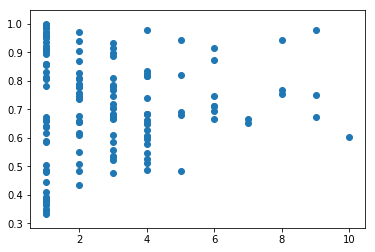

In [59]:
ema_stats, puff_counts = contingent_puff(contingent_ema, puff_marker,15)
make_graph(puff_counts)

Set delta to 5 minutes

percentage of contingent events covered by HTM is:0.5
average number of HTMs detected per contingent event: 1.8021978021978022


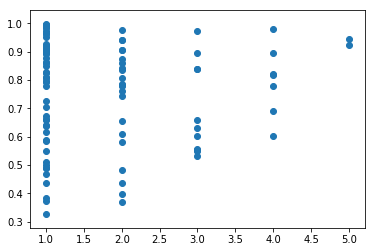

In [60]:
ema_stats, puff_counts = contingent_puff(contingent_ema, puff_marker,5)
make_graph(puff_counts)